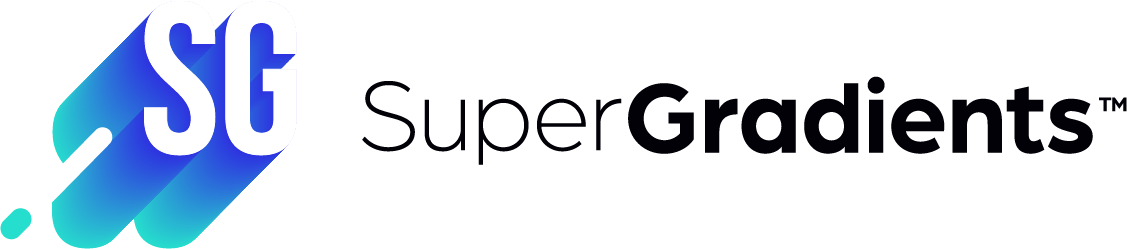

# SuperGradients Transfer Learning Object Detection

In this tutorial we will do transfer learning with a  YOLOX-Nano model pre-trained on COCO2017 to two-classes of PascalVOC for object detection.

The notebook is divided into 7 sections:
1. Experiment setup
2. Dataset definition
3. Architecture definition
4. Training setup
5. Training and Evaluation
6. Predict
7. Convert to ONNX\TensorRT


#Install SG

The cell below will install **super_gradients** which will automatically get all its dependencies. We are also going to install **prettyformatter** to later print dictionaries of various nested parameters with tabluation and **matplotlib** for plotting. Let's import all the installed libraries to make sure they installed succesfully.

In [1]:
! pip install -qq super_gradients==3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to bui

In [2]:
import super_gradients

The console stream is logged into /root/sg_logs/console.log


[2023-12-19 07:46:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-12-19 07:46:32] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-12-19 07:46:33] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-12-19 07:46:46] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-12-19 07:46:46] WARNING - export.py - Failed to import pytorch_quantization
[2023-12-19 07:46:46] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-12-19 07:46:46] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-12-19 07:46:46] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-12-19 07:46:46] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-12-19 07:46:46] WARNING - env_sanity_check.py - 

Both imports worked, so we can proceed with the experiment.

# 1. Experiment setup

We will first initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```
We are going to define **ckpt_root_dir** inside the Colab, later we can use it to start TensorBoard and monitor the run. We should also choose the multi_gpu mode, which tells the trainer which hardware you want to use for your run. The Colab offers one GPU, so as a sanity check let's see it's seen by torch.

In [3]:
import torch


f'{torch.cuda.device_count()} GPU found: {torch.cuda.get_device_name("cuda")}'

'1 GPU found: Tesla T4'

With one available GPU in a notebook a correct choice of mode is DATA_PARALLEL, but depending on your environment, say, if you want to run this code locally, you can change it to OFF (for CPU training), DISTRIBUTED_DATA_PARALLEL or AUTO.

In [4]:
from super_gradients import Trainer
from super_gradients.training import MultiGPUMode


CHECKPOINT_DIR = '.' # Local path
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolox', ckpt_root_dir=CHECKPOINT_DIR)

# 2. Dataset definition


For the sake of this presentation, we'll use **PascalVOC** detection data set. We will limit ourselves to a subset with a few categories from it which we'll choose later. This means that only images where the selected categories are represented will be included, while the rest will be ignored.

Just like many other open-source data sets, PascalVOC had a few releases. We can use it to our advantage to make a dataset bigger, in particular, we can:
* use the test set from 2012 for testing the model;
* combine train2007, val2007, train2012 and val2012 for training the model.

SG trainer is fully compatible with PyTorch data loaders, so you can definitely use your own data for the experiment below if you prefer.

## 2.A. Download data

There is no need for you to download the data manually, SG will do it for you by default. However, if you are planning to plug in your own dataset in the Colab tutorial, it's a good time to do it now and mount it in Colab.

## 2.B. Create data loaders

As mentioned above, the plan is to select a few categories, so for this let's check out which categories we have in PascalVOC detection.

In [6]:
from super_gradients.training.datasets.datasets_conf import PASCAL_VOC_2012_CLASSES_LIST


print(PASCAL_VOC_2012_CLASSES_LIST)

The most obvious choice would be to inlude the 'person' and 'car' categories, because it's among the overlapping categories between PascalVOC and COCO that our model will be pretrained on. With this in mind, let's go ahead and create the data loaders.

In [7]:
from super_gradients.training import dataloaders


class_inclusion_list = ["car", "person"]
num_classes = len(class_inclusion_list)
train_dataloader = dataloaders.get(name='pascal_voc_detection_train',
                                   dataset_params={"class_inclusion_list": class_inclusion_list},
                                   dataloader_params={'num_workers': 2}
                                   )

val_dataloader = dataloaders.get(name='pascal_voc_detection_val',
                                 dataset_params={"class_inclusion_list": class_inclusion_list},
                                 dataloader_params={'num_workers': 2}
                                 )

[2023-12-19 07:47:52] INFO - utils.py - Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar to data/pascal_voc/images/VOCtrainval_06-Nov-2007.tar...
100%|██████████| 439M/439M [00:21<00:00, 21.7MB/s]
[2023-12-19 07:48:14] INFO - utils.py - Extracting to data/pascal_voc/images...
[2023-12-19 07:48:17] INFO - utils.py - Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar to data/pascal_voc/images/VOCtest_06-Nov-2007.tar...
100%|██████████| 430M/430M [00:21<00:00, 21.2MB/s]
[2023-12-19 07:48:38] INFO - utils.py - Extracting to data/pascal_voc/images...
[2023-12-19 07:48:41] INFO - utils.py - Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar to data/pascal_voc/images/VOCtrainval_11-May-2012.tar...
100%|██████████| 1.86G/1.86G [01:29<00:00, 22.3MB/s]
[2023-12-19 07:50:11] INFO - utils.py - Extracting to data/pascal_voc/images...
test2007: 100%|██████████| 4952/4952 [00:01<00:00, 2657.22it/

Great, the data was succesfully downloaded and we can take a look at some images.

Notice that we are changing the *num_workers* parameter of the dataloader. It should be roughly equal to the number of CPU cores. The default value is 8, but the Colab offers only 2 cores.

In [7]:
train_dataloader.dataloader_params

{'num_workers': 2,
 'shuffle': True,
 'batch_size': 16,
 'drop_last': True,
 'pin_memory': True,
 'worker_init_fn': <function super_gradients.training.datasets.datasets_utils.worker_init_reset_seed(worker_id)>,
 'collate_fn': <super_gradients.training.utils.collate_fn.detection_collate_fn.DetectionCollateFN at 0x7aa2ac2bce80>}

In [8]:
train_dataloader.dataset.dataset_params

{'data_dir': './data/pascal_voc/', 'input_dim': [320, 320], 'cache': False, 'cache_dir': None, 'transforms': [{'DetectionPaddedRescale': {'input_dim': [320, 320]}}, {'DetectionTargetsFormatTransform': {'input_dim': [320, 320], 'output_format': 'LABEL_CXCYWH'}}], 'class_inclusion_list': ['car', 'person'], 'max_num_samples': None, 'download': True}

This shows us that the images we'll be dealing with are in the 320x320 resolution.


# 3. Architecture definition

SG includes implementations of many different architectures for object detection tasks that can be found [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).

As mentioned earlier, the architecture that we'll use is based on [YOLOX: Exceeding YOLO Series in 2021](https://arxiv.org/pdf/2107.08430.pdf) and its performance can be view [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).
This architecture was pretrained on COCO2017 datasets.

There are 80 categories in COCO detection, but we want only 2 for our PascalVOC subset, which means that the predicting layers of the pre-trained model don't work for us. There is a bit of magic for this use case behind the scenes that SuperGradients does for you: you can specify **num_classes** during model construction and it'll automatically replace model's head to a suitable one. As for the pre-trained weights, they will be used for all layers except of those that are replaced.

In [8]:
from super_gradients.training import models

model = models.get("yolox_n", pretrained_weights="coco", num_classes=num_classes)

print('Num classes in the model:', model.num_classes)

Indexing dataset annotations: 100%|██████████| 4952/4952 [00:01<00:00, 4459.13it/s]
/usr/local/lib/python3.10/dist-packages/super_gradients/common/deprecate.py:168: DeprecationWarning: Parameter `arch_params.channels_in` is deprecated since version `3.3.0` and will be removed in version `4.0.0`.
Please update your code to use the `arch_params.in_channels` instead of `arch_params.channels_in`.
  warnings.warn(message, DeprecationWarning)
Downloading: "https://sghub.deci.ai/models/yolox_n_coco.pth" to /root/.cache/torch/hub/checkpoints/yolox_n_coco.pth
100%|██████████| 11.1M/11.1M [00:00<00:00, 20.5MB/s]
[2023-12-19 07:53:29] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


That being said, SG allows you to use one of SG implemented architectures or your custom architecture, as long as it inherits torch.nn.Module.

# 4. Training setup


With a model and data in hand we have almost everything to start training, only the recipe is yet to be defined. For this use case we can start with the training recipe that was used for pre-training our model. Let's load it and take a look at the training parameters it gives us.

In [10]:
from super_gradients.training import training_hyperparams


train_params = training_hyperparams.get('coco2017_yolox')

train_params

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num classes in the model: 2


{'resume': None,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'CosineLRScheduler',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 5,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 15,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.05,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'SGD',
 'optimizer_params': {'momentum': 0.9, 'weight_decay': 0.0005, 'nesterov': True},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': True,
 'loss': 'YoloXDetectionLoss',
 'criterion_params': {'strides': [8, 16, 32], 'num_classes': 80},
 'ema': True,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [],
 'valid_metrics_list': [{'DetectionMetrics': {'normalize_targets': True, 'post_prediction_callback': YoloXPostPredictionCallback(), 'num_cls': 80}}],
 'metric_to_watch': 'mAP

If it looks like a daunting numbers of parameters, remember that they define everything necessary for SG to know how to train your model: metrics, an optimizer with its parameters, a loss, EMA parameters, various callbacks, etc. If you wish, take a moment to go over them and get aquainted, for the most part, the structure is shared between all the recipes in SuperGradients.

For the sake of this tutorial, we'll change a few parameters above to values that make more sense for a quick transer learning. We'll set a small number of epochs, disable warmup and cooldown, pass a correct number of classes into the loss (criterion) and set a much smaller learning rate not to alter the models weights too much too fast.

In [11]:
train_params['max_epochs'] = 5
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = num_classes
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.0005
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False

# 5. Training and evaluation


## 5.A. Connect tensor board

You can instantiate a tensorboard to be able to monitor the run live.

**NOTE: There is currently an issue with tensorboard on many browsers (see [official issue](https://github.com/googlecolab/colabtools/issues/3990#issuecomment-1785125682)). We commented out the tensorboard command to avoid this bug but you can try to uncomment and run it yourself.**

In [12]:
# %load_ext tensorboard
# %tensorboard --logdir $CHECKPOINT_DIR --bind_all

## 5.B. Start Training

The logs and the checkpoint for the latest epoch will be kept in your experiment folder.

To start training we'll call train(...) and provide it with the objects we construted above: the model, the training parameters and the data loaders.

**Note:** While training, don't forget to refresh the tensorboard with the arrow on the top right.

In [13]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2023-12-18 16:55:00] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231218_165500_894437`
[2023-12-18 16:55:00] INFO - sg_trainer.py - Checkpoints directory: ./transfer_learning_object_detection_yolox/RUN_20231218_165500_894437
[2023-12-18 16:55:01] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}


The console stream is now moved to ./transfer_learning_object_detection_yolox/RUN_20231218_165500_894437/console_Dec18_16_55_00.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2023-12-18 16:55:01] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            7309       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Ite

SUMMARY OF EPOCH 0
├── Train
│   ├── Yoloxdetectionloss/iou = 0.6583
│   ├── Yoloxdetectionloss/obj = 2.9798
│   ├── Yoloxdetectionloss/cls = 0.9373
│   ├── Yoloxdetectionloss/l1 = 0.0
│   ├── Yoloxdetectionloss/num_fg = 3.8859
│   └── Yoloxdetectionloss/loss = 7.2083
└── Validation
    ├── Yoloxdetectionloss/iou = 0.534
    ├── Yoloxdetectionloss/obj = 1.7524
    ├── Yoloxdetectionloss/cls = 0.7211
    ├── Yoloxdetectionloss/l1 = 0.0
    ├── Yoloxdetectionloss/num_fg = 5.2291
    ├── Yoloxdetectionloss/loss = 5.1437
    ├── Precision@0.50:0.95 = 0.1354
    ├── Recall@0.50:0.95 = 0.3677
    ├── Map@0.50:0.95 = 0.2326
    └── F1@0.50:0.95 = 0.1978



Validating epoch 1: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]
[2023-12-18 16:59:47] INFO - base_sg_logger.py - Checkpoint saved in ./transfer_learning_object_detection_yolox/RUN_20231218_165500_894437/ckpt_best.pth
[2023-12-18 16:59:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.34150370955467224
Train epoch 2:   0%|          | 0/456 [00:00<?, ?it/s]

SUMMARY OF EPOCH 1
├── Train
│   ├── Yoloxdetectionloss/iou = 0.5358
│   │   ├── Epoch N-1      = 0.6583 (↘ -0.1225)
│   │   └── Best until now = 0.6583 (↘ -0.1225)
│   ├── Yoloxdetectionloss/obj = 1.7116
│   │   ├── Epoch N-1      = 2.9798 (↘ -1.2682)
│   │   └── Best until now = 2.9798 (↘ -1.2682)
│   ├── Yoloxdetectionloss/cls = 0.7183
│   │   ├── Epoch N-1      = 0.9373 (↘ -0.2189)
│   │   └── Best until now = 0.9373 (↘ -0.2189)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 5.3163
│   │   ├── Epoch N-1      = 3.8859 (↗ 1.4305)
│   │   └── Best until now = 3.8859 (↗ 1.4305)
│   └── Yoloxdetectionloss/loss = 5.1088
│       ├── Epoch N-1      = 7.2083 (↘ -2.0995)
│       └── Best until now = 7.2083 (↘ -2.0995)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4785
    │   ├── Epoch N-1      = 0.534  (↘ -0.0555)
    │   └── Best until now = 0.534  (↘ -0.0555)
    ├── Yoloxd

Validating epoch 2: 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]
[2023-12-18 17:02:07] INFO - base_sg_logger.py - Checkpoint saved in ./transfer_learning_object_detection_yolox/RUN_20231218_165500_894437/ckpt_best.pth
[2023-12-18 17:02:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.36540597677230835
Train epoch 3:   0%|          | 0/456 [00:00<?, ?it/s]

SUMMARY OF EPOCH 2
├── Train
│   ├── Yoloxdetectionloss/iou = 0.4961
│   │   ├── Epoch N-1      = 0.5358 (↘ -0.0397)
│   │   └── Best until now = 0.5358 (↘ -0.0397)
│   ├── Yoloxdetectionloss/obj = 1.4781
│   │   ├── Epoch N-1      = 1.7116 (↘ -0.2335)
│   │   └── Best until now = 1.7116 (↘ -0.2335)
│   ├── Yoloxdetectionloss/cls = 0.675
│   │   ├── Epoch N-1      = 0.7183 (↘ -0.0433)
│   │   └── Best until now = 0.7183 (↘ -0.0433)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 5.7767
│   │   ├── Epoch N-1      = 5.3163 (↗ 0.4603)
│   │   └── Best until now = 3.8859 (↗ 1.8908)
│   └── Yoloxdetectionloss/loss = 4.6334
│       ├── Epoch N-1      = 5.1088 (↘ -0.4754)
│       └── Best until now = 5.1088 (↘ -0.4754)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4672
    │   ├── Epoch N-1      = 0.4785 (↘ -0.0113)
    │   └── Best until now = 0.4785 (↘ -0.0113)
    ├── Yoloxde

Validating epoch 3: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]
[2023-12-18 17:04:27] INFO - base_sg_logger.py - Checkpoint saved in ./transfer_learning_object_detection_yolox/RUN_20231218_165500_894437/ckpt_best.pth
[2023-12-18 17:04:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3713436722755432
Train epoch 4:   0%|          | 0/456 [00:00<?, ?it/s]

SUMMARY OF EPOCH 3
├── Train
│   ├── Yoloxdetectionloss/iou = 0.4703
│   │   ├── Epoch N-1      = 0.4961 (↘ -0.0257)
│   │   └── Best until now = 0.4961 (↘ -0.0257)
│   ├── Yoloxdetectionloss/obj = 1.3545
│   │   ├── Epoch N-1      = 1.4781 (↘ -0.1236)
│   │   └── Best until now = 1.4781 (↘ -0.1236)
│   ├── Yoloxdetectionloss/cls = 0.6444
│   │   ├── Epoch N-1      = 0.675  (↘ -0.0306)
│   │   └── Best until now = 0.675  (↘ -0.0306)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 6.0172
│   │   ├── Epoch N-1      = 5.7767 (↗ 0.2406)
│   │   └── Best until now = 3.8859 (↗ 2.1314)
│   └── Yoloxdetectionloss/loss = 4.3506
│       ├── Epoch N-1      = 4.6334 (↘ -0.2828)
│       └── Best until now = 4.6334 (↘ -0.2828)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4641
    │   ├── Epoch N-1      = 0.4672 (↘ -0.0031)
    │   └── Best until now = 0.4672 (↘ -0.0031)
    ├── Yoloxd

Validating epoch 4: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


You should get to ±36.5 mAP, which corresponds to the COCO mAP @0.5:0.95 with iou=0.65 and confidence threshold of 0.01.

**Note: Feel free to train more to improve the results, the model will not converge after 5 epochs!**

# 6. Predict

Let's inspect how our trained model works after training for 5 epochs. For this we use the [predict API](https://docs.deci.ai/super-gradients/documentation/source/ModelPredictions.html) available for Super Gradient models.

In the nutshell, all you need to do is to call `model.predict(image)`, where image can be anything from numpy array, image url, a folder with images of video file.  

[2023-12-18 17:06:49] INFO - base_sg_logger.py - Checkpoint saved in ./transfer_learning_object_detection_yolox/RUN_20231218_165500_894437/ckpt_best.pth
[2023-12-18 17:06:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3784121870994568
[2023-12-18 17:06:49] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


SUMMARY OF EPOCH 4
├── Train
│   ├── Yoloxdetectionloss/iou = 0.454
│   │   ├── Epoch N-1      = 0.4703 (↘ -0.0163)
│   │   └── Best until now = 0.4703 (↘ -0.0163)
│   ├── Yoloxdetectionloss/obj = 1.2256
│   │   ├── Epoch N-1      = 1.3545 (↘ -0.1289)
│   │   └── Best until now = 1.3545 (↘ -0.1289)
│   ├── Yoloxdetectionloss/cls = 0.6236
│   │   ├── Epoch N-1      = 0.6444 (↘ -0.0207)
│   │   └── Best until now = 0.6444 (↘ -0.0207)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 6.1824
│   │   ├── Epoch N-1      = 6.0172 (↗ 0.1651)
│   │   └── Best until now = 3.8859 (↗ 2.2965)
│   └── Yoloxdetectionloss/loss = 4.1193
│       ├── Epoch N-1      = 4.3506 (↘ -0.2313)
│       └── Best until now = 4.3506 (↘ -0.2313)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4612
    │   ├── Epoch N-1      = 0.4641 (↘ -0.0029)
    │   └── Best until now = 0.4641 (↘ -0.0029)
    ├── Yoloxde

[2023-12-18 17:06:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


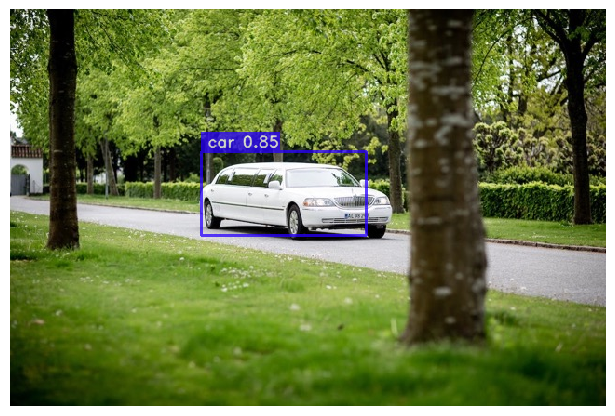

In [14]:
url = 'https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/images/examples/car.jpeg?raw=true'
prediction = model.predict(url)
prediction.show()

# 7. Convert to ONNX/TensorRT

SuperGradients provides an API to export your models to ONNX/TensoRT, you can check out [this tutorial](https://docs.deci.ai/super-gradients/latest/documentation/source/models_export.html) for more information.

**Note: There is an [issue](https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working) in Colab when installing `onnx_graphsurgeon`, the following line aims at patching it**

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [10]:
!pip install onnx_graphsurgeon==0.3.27 --extra-index-url https://pypi.ngc.nvidia.com

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num classes in the model: 2
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 6.7 MB/s eta 0:00:00


In [11]:
export_result = model.export(output="myexport.onnx")

/usr/local/lib/python3.10/dist-packages/super_gradients/training/models/detection_models/yolo_base.py:270: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != output.shape[2:4]:
/usr/local/lib/python3.10/dist-packages/onnx_graphsurgeon/importers/onnx_importer.py:87: DeprecationWarning: `mapping.TENSOR_TYPE_TO_NP_TYPE` is now deprecated and will be removed in the next release or so.To silence this warning, please use `helper.{self._future_function}` instead.
  return onnx.mapping.TENSOR_TYPE_TO_NP_TYPE[onnx_type]
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5856: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX operators, including Reshape, Transpose,

With the result object, you can directly get all the instructions on how to run the exported model:

In [12]:
export_result

Model exported successfully to myexport.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.1
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("myexport.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    inputs = [o.name for o in session.get_inputs()]


We can directly copy the instructions to our code, run it and get inference results from our ONNX model.